# Tesis de Licenciatura en Astronomía

## Manuel López Vargas

# Detección de señales en series de tiempo astronómicas utilizando algoritmos de Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.signal as signal
from astropy.timeseries import LombScargle
from gatspy.periodic import LombScargleFast
from gatspy import datasets, periodic
import sympy
from scipy.integrate import odeint
from scipy import integrate
from mpl_toolkits.mplot3d.axes3d import Axes3D
import random

In [76]:
A = 3
B = 4
C = 4
w1 = 3.2 #rad/sec
w2 = 2.3 #rad/sec
w3 = 2.9 #rad/sec
psi1 = 1. #rad
psi2 = 1.8 #rad
n_in = 300
n_out = 100000

Generamos aleatoriamente tiempos de muestreo.

In [85]:
seed_value = 1 
rng = np.random.default_rng(seed_value)
t = rng.uniform(0, 10*np.pi, n_in)

Ploteamos dos ondas sinusoidales con freciencias diferentes ($\frac{w1}{w2}\neq Q$) para los tiempos seleccionados.

In [86]:
x = A * np.sin(w1*t + psi1) + B * np.sin(w2*t + psi2) 

Definimos un arreglo de frecuencias para el que se calculará el periodograma

In [87]:
w = np.linspace(0.01, 10, n_out)
periods = 2 * np.pi / w

Calculo el Lomb-Scargle periodograma

In [88]:
pgram = signal.lombscargle(t, x, w, normalize=True)

Ploteo los datos de salida

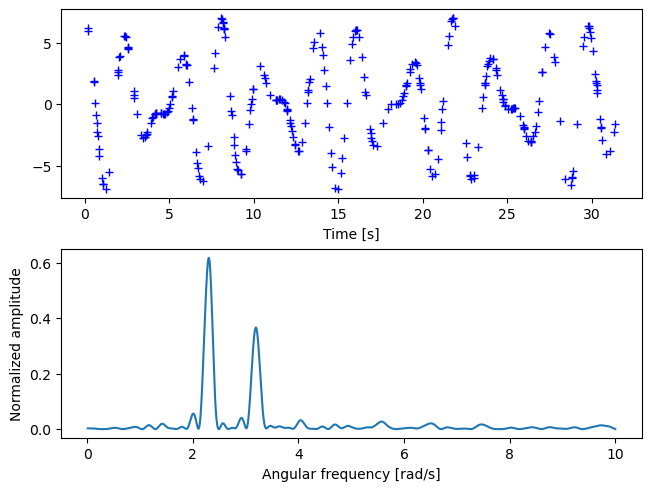

In [89]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

Los resultados no cambian cuando $(\frac{w1}{w2}= Q)$

Probamos con otro código.

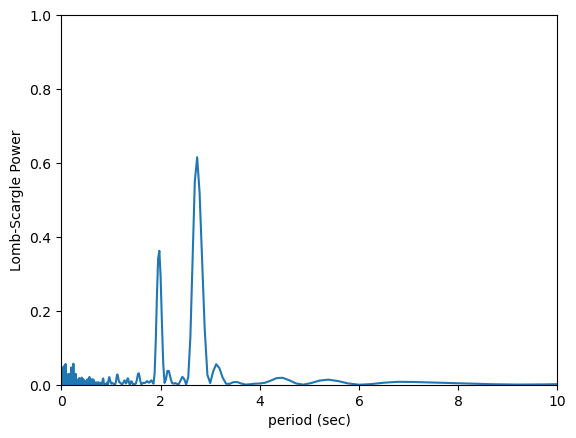

In [90]:
model = LombScargleFast().fit(t, x)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1.0),
        xlabel='period (sec)',
        ylabel='Lomb-Scargle Power');

In [91]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 2 #limite infererior del intervalo
f_end = 4.0 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, x)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.201
 - Using 10 steps per peak; omega_step = 0.0201
 - User-specified period range:  2 to 4
 - Computing periods at 80 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 500 steps
La frecuencia encontrada es: 2.3154590749405117


#### Calculamos la False-Alarm Probablility (FAP).

La FAP se define como FAP(z) = $1 - [P_{single0}(z)]^{N_{eff.}}$ donde $N_{eff.}= f_{max}T$

Utilizando la libreria astropy.timeseries vamos a calcular la FAP.

In [594]:
ls = LombScargle(t, x, normalization='standard')
power = ls.power(w)
print(power.max())  

0.5691154553066237


In [595]:
fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

FAP = 5.090845778674334e-24


Lo que esto nos dice es que, suponiendo que no haya una señal periódica en los datos, observaremos un pico tan alto o más con una probabilidad de $3.118\ x10^{-22}$, lo que nos da una fuerte indicación de que hay una señal periódica presente en los datos.

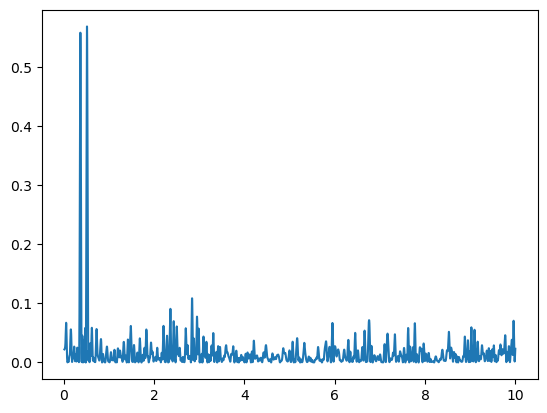

In [596]:
plt.plot(w,power);

In [597]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.11956825, 0.12864355, 0.14872932])

Esto nos indica que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,119; para el 5%, 0,129, y para el 1%, 0,149.

## Ahora simularemos nuestros datos utilizando potenciales con simetria esférica.

### Probamos primero con el siguiente potencial:

### $\phi(r) = -\frac{GM}{r} $

Luego

### $\ddot{x} = - \nabla \phi(r)$

Podemos descomponer esta ecuación diferencial de segundo orden en dos ecuaciones de primer orden.

### $\dot{x} = v\ \ \ ,\ \ x(0) = x_0$
### $\dot{v} = -\nabla \phi\ \ \ , \ \ \dot{x}(0) = \dot{x}_0$

Planteamos las condiciones iniciales.

### $X_o$=1  ,   $Y_o$=0
### $\dot{X_0}$=0  ,   $\dot{Y_0}$=0.1

### GM=1

Resolvemos las ecuaciones diferenciales acopladas de forma numérica:

In [102]:
# Elegimos los tiempos de observación t
seed_value = 10 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 15, n_in)

In [103]:
t.sort()

In [104]:
# Definimos el sistema de ecuaciones
def f(xyv_xv_y, t):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -x/(x**2+y**2)**(3/2),
           -y/(x**2+y**2)**(3/2)]


# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y1 = integrate.odeint(f, xyv_xv_y0, t)

In [105]:
x_1 = xyv_xv_y1[:,0]
y_1 = xyv_xv_y1[:,1]
v_x_1 = xyv_xv_y1[:,2]
v_y_1 = xyv_xv_y1[:,3]

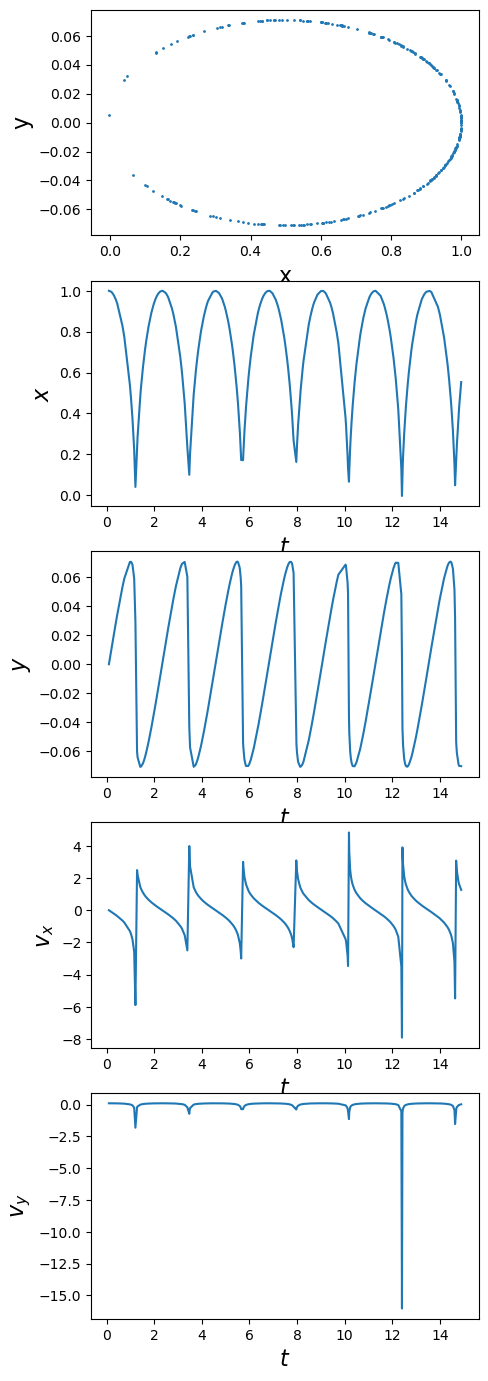

In [106]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_1,y_1, 'o', ms=1)
ax2.plot(t, x_1)
ax3.plot(t, y_1)
ax4.plot(t, v_x_1)
ax5.plot(t, v_y_1)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Con esto, calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [107]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.01, 10, n_out)
periods = 2 * np.pi / w

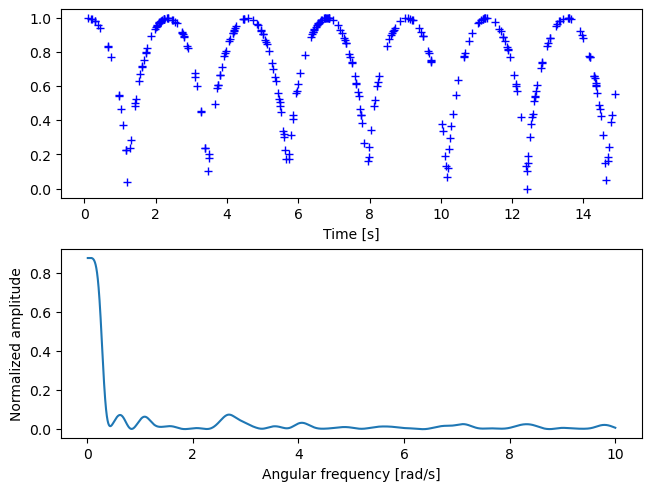

In [108]:
pgram = signal.lombscargle(t, x_1, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

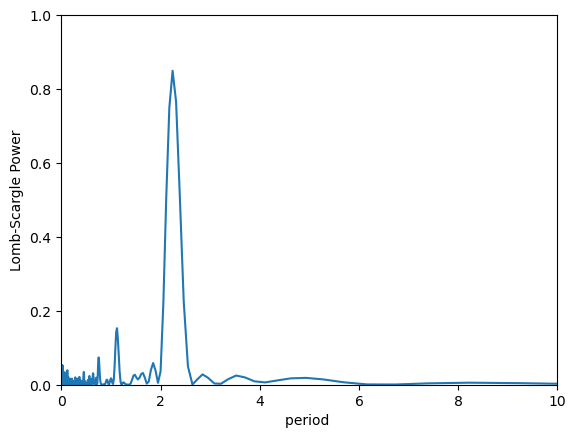

In [109]:
model = LombScargleFast().fit(t, x_1)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [111]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 1.5 #limite infererior del intervalo
f_end = 5. #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, x_1)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.425
 - Using 10 steps per peak; omega_step = 0.0425
 - User-specified period range:  1.5 to 5
 - Computing periods at 71 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 2.8261289828299394


In [112]:
ls = LombScargle(t, x_1, normalization='standard')
power = ls.power(w)
print('Altura del pico máximo:',power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

Altura del pico máximo: 0.8498827881207243
FAP = 1.1071044971932976e-118


In [113]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.06548677, 0.070241  , 0.0808616 ])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0658; para el 5%, 0,0706, y para el 1%, 0,0812.

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. Pero la que nos interes es el pico mas alto.

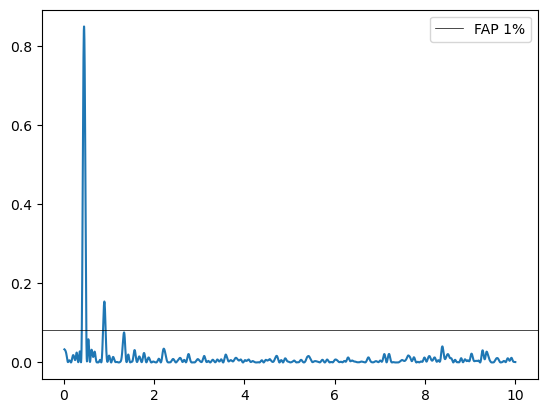

In [114]:
plt.plot(w,power)
plt.axhline(0.0812, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

#### Coordenada Y

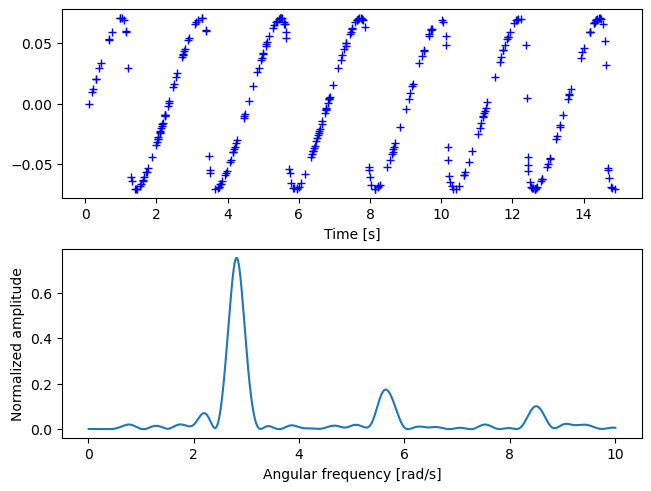

In [115]:
pgram = signal.lombscargle(t, y_1, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

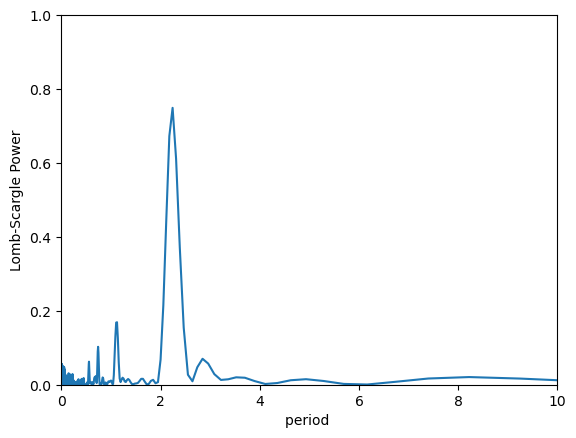

In [116]:
model = LombScargleFast().fit(t, y_1)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [117]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 1.5 #limite infererior del intervalo
f_end = 5. #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_1)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.425
 - Using 10 steps per peak; omega_step = 0.0425
 - User-specified period range:  1.5 to 5
 - Computing periods at 71 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 2.829526151490965


In [119]:
ls = LombScargle(t, y_1, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.7522929795485312
FAP = 1.6175882894355516e-86


In [565]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.06555458, 0.07030822, 0.08092762])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0658; para el 5%, 0,0706, y para el 1%, 0,0812.

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. Pero la que nos interes es el pico mas alto.

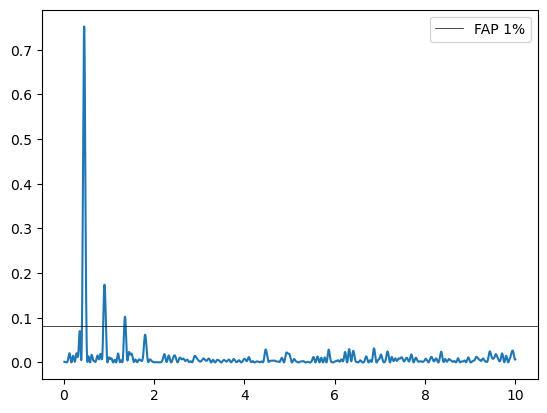

In [120]:
plt.plot(w,power)
plt.axhline(0.0812, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

## Pasamos a un potencial de la forma:

### $\phi = 1 - r²$

#### Luego, resolvemos el mismo sistema de ec. diferenciales para el $\phi$ mencionado.

In [121]:
# Elegimos los tiempos de observación t
seed_value = 20 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 10, n_in)

In [122]:
t.sort()

In [123]:
# Definimos el sistema de ecuaciones
def f(xyv_xv_y, t):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -x*2,
           -y*2]


# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y2 = integrate.odeint(f, xyv_xv_y0, t)

In [124]:
x_2 = xyv_xv_y2[:,0]
y_2 = xyv_xv_y2[:,1]
v_x_2 = xyv_xv_y2[:,2]
v_y_2 = xyv_xv_y2[:,3]

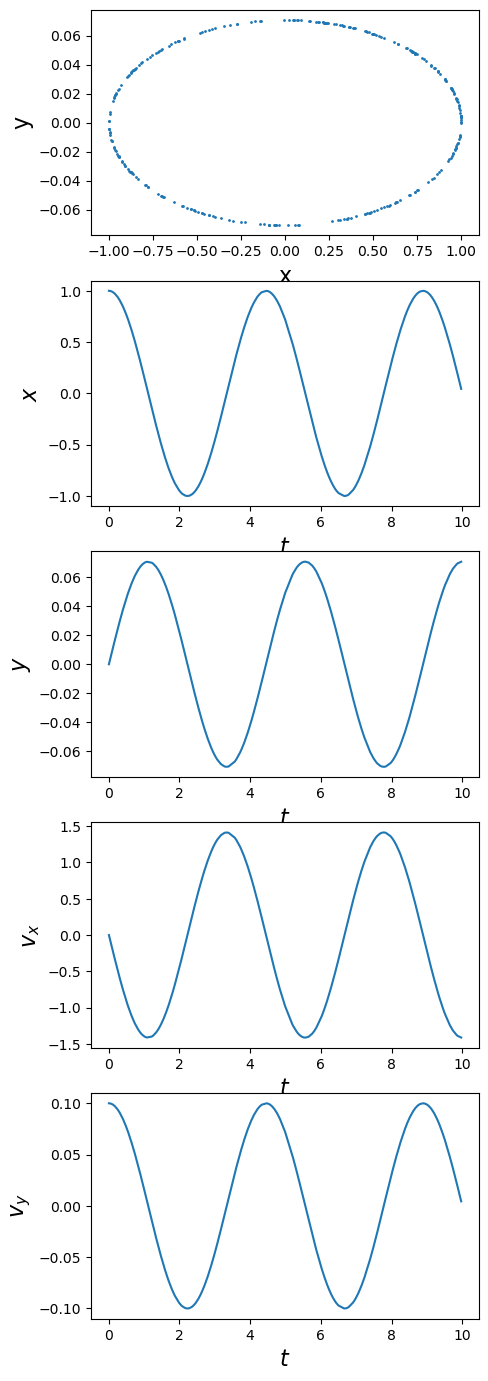

In [125]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_2,y_2, 'o', ms=1)
ax2.plot(t, x_2)
ax3.plot(t, y_2)
ax4.plot(t, v_x_2)
ax5.plot(t, v_y_2)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Con esto, calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [126]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.01, 10, n_out)
periods = 2 * np.pi / w

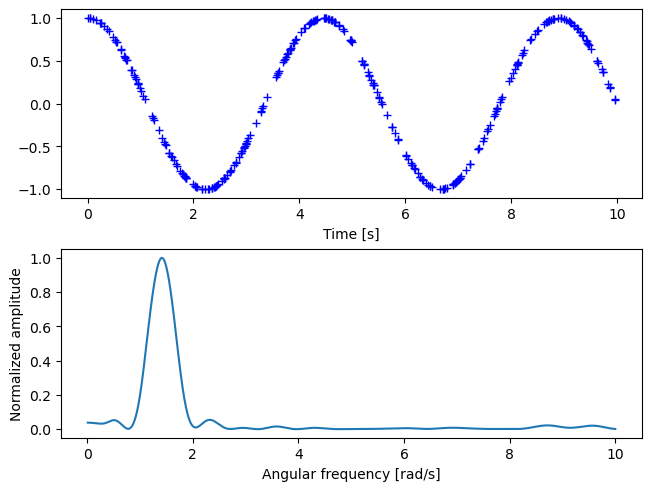

In [127]:
pgram = signal.lombscargle(t, x_2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

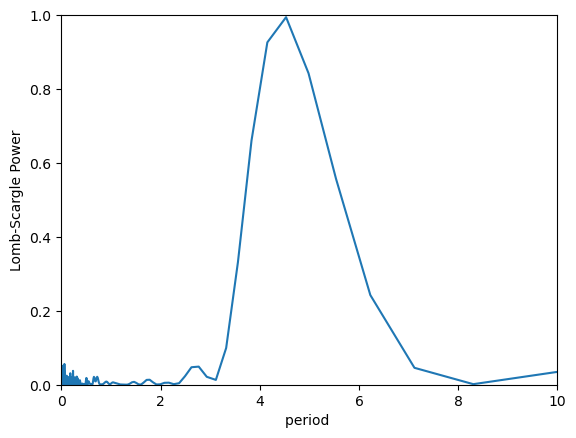

In [128]:
model = LombScargleFast().fit(t, x_2)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [130]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 1.5 #limite infererior del intervalo
f_end = 5. #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, x_2)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.631
 - Using 10 steps per peak; omega_step = 0.0631
 - User-specified period range:  1.5 to 5
 - Computing periods at 48 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 500 steps
La frecuencia encontrada es: 1.4445275071565074


In [132]:
ls = LombScargle(t, x_2, normalization='standard')
power = ls.power(w)
print('Altura del pico máximo:',power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

Altura del pico máximo: 1.0000000064393493
FAP = nan


In [133]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06549245, 0.07024663, 0.08086714])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0652; para el 5%, 0,07, y para el 1%, 0,0806.

- Vemos entonces que se encontro un solo pico con un FAP menor al 1%.

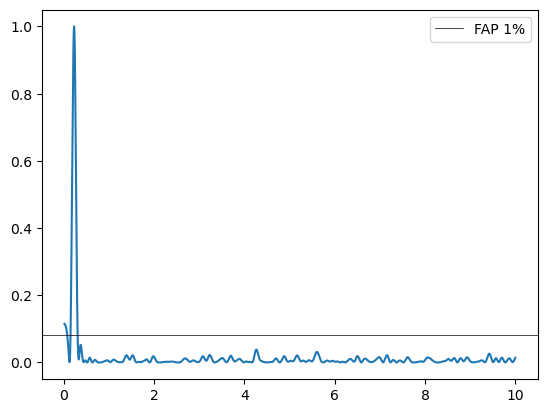

In [134]:
plt.plot(w,power)
plt.axhline(0.0808, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

#### Coordenada Y

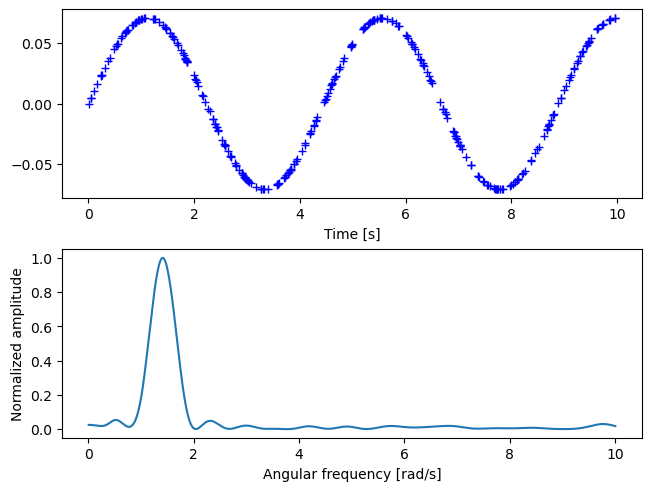

In [135]:
pgram = signal.lombscargle(t, y_2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

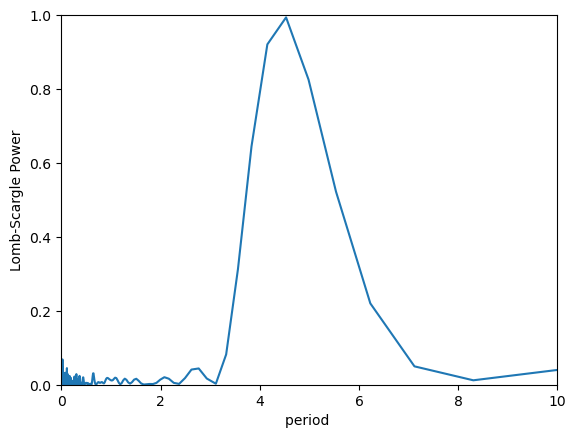

In [136]:
model = LombScargleFast().fit(t, y_2)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [137]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 1.5 #limite infererior del intervalo
f_end = 5. #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_2)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.631
 - Using 10 steps per peak; omega_step = 0.0631
 - User-specified period range:  1.5 to 5
 - Computing periods at 48 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 500 steps
La frecuencia encontrada es: 1.4445275071565074


In [139]:
ls = LombScargle(t, y_2, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

1.0000000036480727
FAP = nan


In [140]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.06549245, 0.07024663, 0.08086714])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0652; para el 5%, 0,07, y para el 1%, 0,0806.

- Vemos entonces que se encontro un solo pico con un FAP menor al 1%.

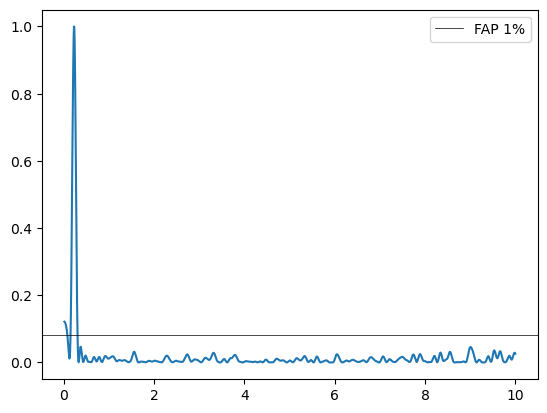

In [141]:
plt.plot(w,power)
plt.axhline(0.0808, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

### Pasamos ahora a un potencial de la forma:

### $\phi = \frac{-GM}{\sqrt{b²+r²}}$

Resolvemos el sistema de ecuaciones diferenciales

In [162]:
# Elegimos los tiempos de observación t
seed_value = 30 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 20, n_in)

In [163]:
t.sort()

In [164]:
# Definimos el sistema de ecuaciones

def f(xyv_xv_y, t, b, a):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -x/(a*b**2+x**2+y**2)**(3/2),
           -y/(b**2+x**2+y**2)**(3/2)]

b, a = 0.1, 1

# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y3 = integrate.odeint(f, xyv_xv_y0, t, args=(b,a))

In [165]:
x_3 = xyv_xv_y3[:,0]
y_3 = xyv_xv_y3[:,1]
v_x_3 = xyv_xv_y3[:,2]
v_y_3= xyv_xv_y3[:,3]

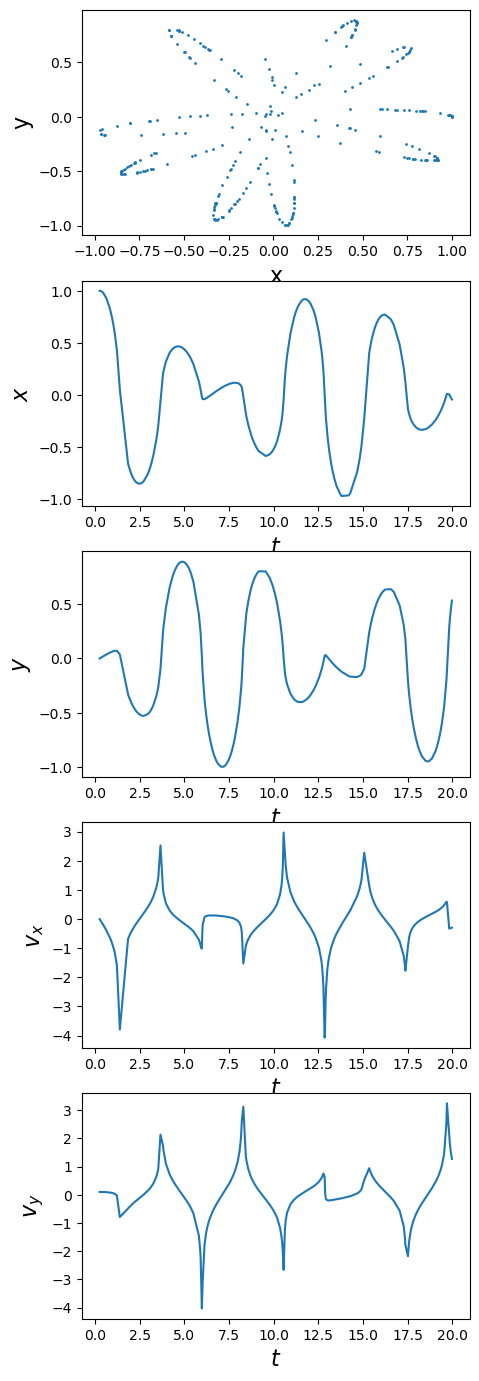

In [166]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_3,y_3, 'o', ms=1)
ax2.plot(t, x_3)
ax3.plot(t, y_3)
ax4.plot(t, v_x_3)
ax5.plot(t, v_y_3)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [167]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.01, 10, n_out)
periods = 2 * np.pi / w

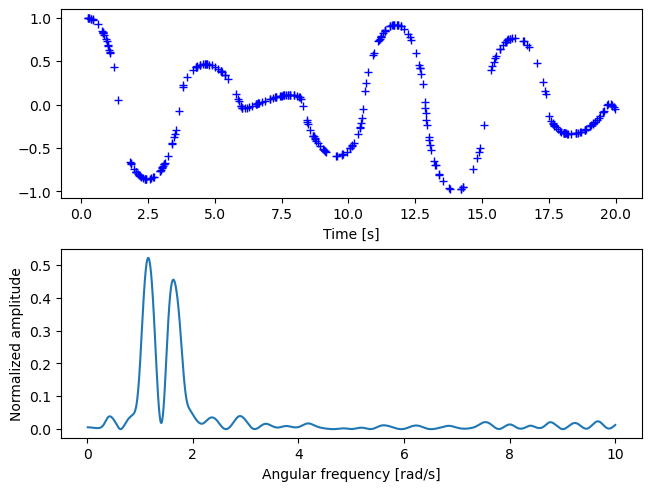

In [168]:
pgram = signal.lombscargle(t, x_3, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_3, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

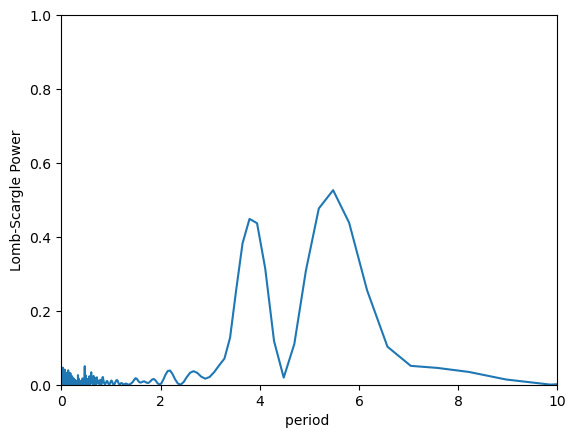

In [169]:
model = LombScargleFast().fit(t, x_3)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [170]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 3.5 #limite infererior del intervalo
f_end = 4.5 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, x_3)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.319
 - Using 10 steps per peak; omega_step = 0.0319
 - User-specified period range:  3.5 to 4.5
 - Computing periods at 14 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 1.6498635241320292


In [171]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 4.5 #limite infererior del intervalo
f_end = 6.5 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, x_3)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.319
 - Using 10 steps per peak; omega_step = 0.0319
 - User-specified period range:  4.4 to 6.5
 - Computing periods at 15 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 1.1730922343716583


In [172]:
ls = LombScargle(t, x_3, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.5278198789158062
FAP = 4.101181597521338e-45


In [173]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.0657296 , 0.07048172, 0.08109802])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0654; para el 5%, 0,07016, y para el 1%, 0,0808.

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

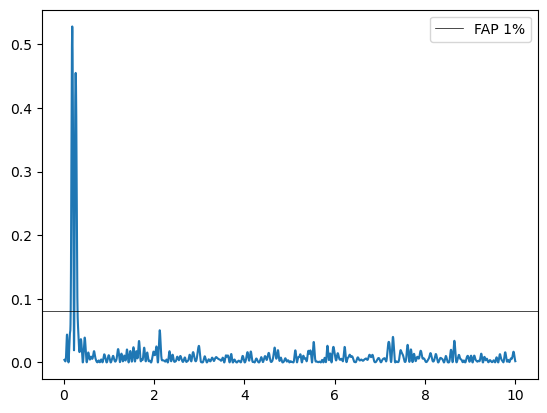

In [154]:
plt.plot(w,power)
plt.axhline(0.0811, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

#### Coordenada Y

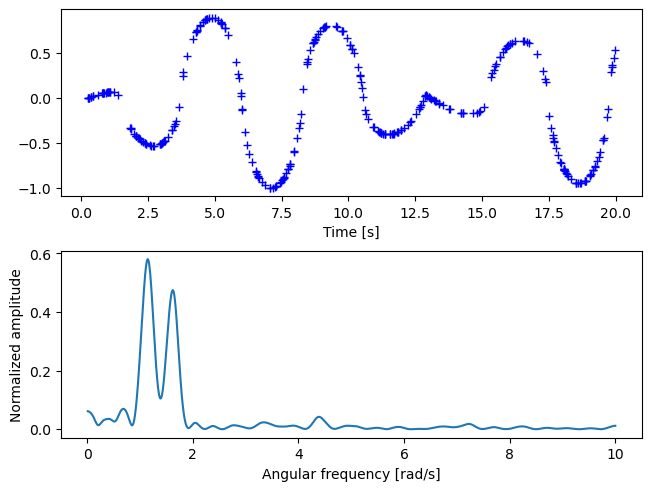

In [155]:
pgram = signal.lombscargle(t, y_3, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_3, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

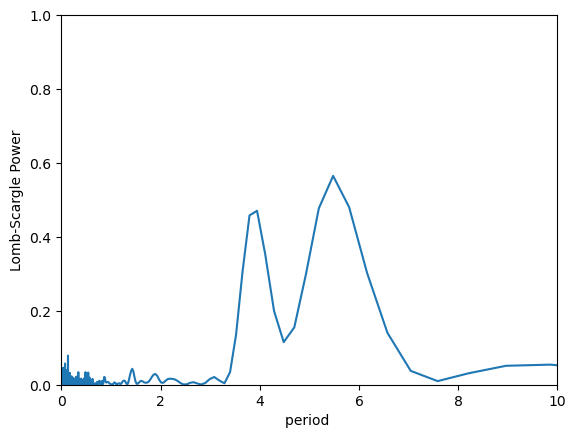

In [156]:
model = LombScargleFast().fit(t, y_3)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [157]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 3.5 #limite infererior del intervalo
f_end = 5 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_3)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.319
 - Using 10 steps per peak; omega_step = 0.0319
 - User-specified period range:  3.5 to 5
 - Computing periods at 18 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 1.6364000590032364


In [158]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 5 #limite infererior del intervalo
f_end = 7 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_3)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.319
 - Using 10 steps per peak; omega_step = 0.0319
 - User-specified period range:  4.9 to 7
 - Computing periods at 13 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 1.1830573354386726


In [159]:
ls = LombScargle(t, y_3, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.5650802238376894
FAP = 2.209701830723841e-50


In [160]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.0657296 , 0.07048172, 0.08109802])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0652; para el 5%, 0,07, y para el 1%, 0,0806.

- Vemos entonces que se encontro un solo pico con un FAP menor al 1%.

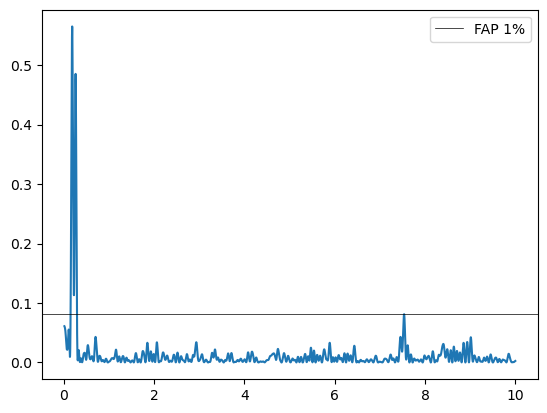

In [161]:
plt.plot(w,power)
plt.axhline(0.0811, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

### Pasamos ahora a un potencial de la forma:

### $\phi = c(\frac{r_0}{r})^{\alpha}$

Resolvemos el sistema de ecuaciones diferenciales

In [174]:
# Elegimos los tiempos de observación t
seed_value = 40 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 20, n_in)

In [175]:
t.sort()

In [176]:
# Definimos el sistema de ecuaciones

def f(xyv_xv_y, t, c, r0, alpha):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -(c*alpha*x)*(r0/np.sqrt(x**2+y**2))**(alpha-1)*r0/(x**2+y**2)**(3/2),
           -(c*alpha*y)*(r0/np.sqrt(x**2+y**2))**(alpha-1)*r0/(x**2+y**2)**(3/2)]

c, r0, alpha = 1, 1, 0.5

# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y4 = integrate.odeint(f, xyv_xv_y0, t, args=(c, r0, alpha))

In [177]:
x_4 = xyv_xv_y4[:,0]
y_4 = xyv_xv_y4[:,1]
v_x_4 = xyv_xv_y4[:,2]
v_y_4 = xyv_xv_y4[:,3]

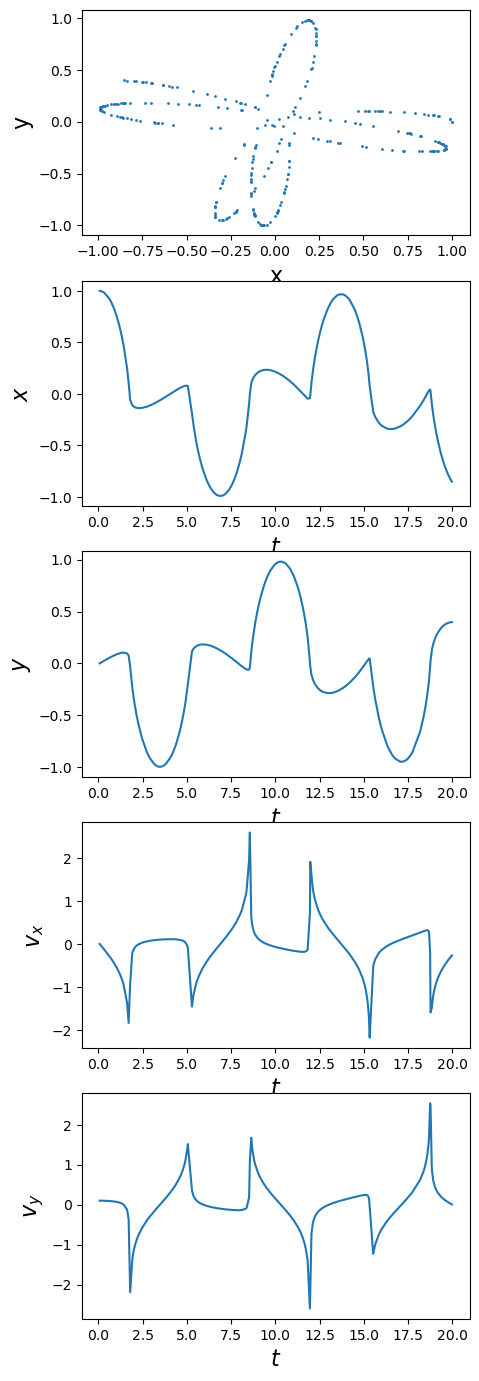

In [178]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_4,y_4, 'o', ms=1)
ax2.plot(t, x_4)
ax3.plot(t, y_4)
ax4.plot(t, v_x_4)
ax5.plot(t, v_y_4)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [179]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.01, 20, n_out)
periods = 2 * np.pi / w

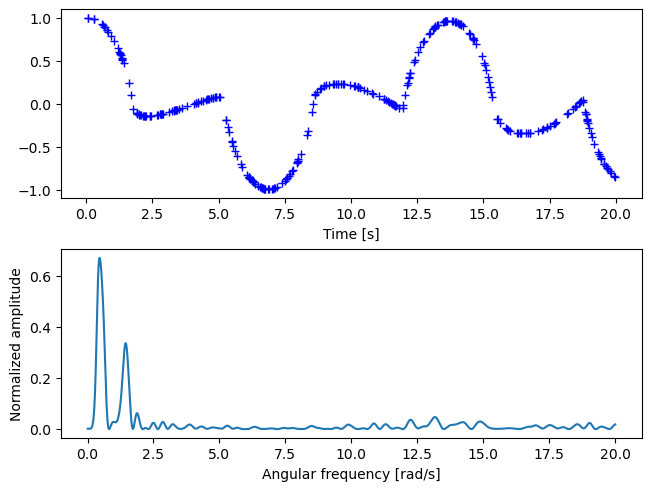

In [180]:
pgram = signal.lombscargle(t, x_4, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_4, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax.set_xlim(0,10)
plt.show();

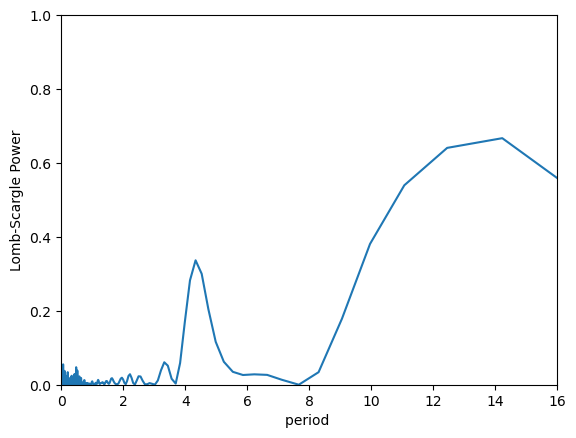

In [181]:
model = LombScargleFast().fit(t, x_4)
periods, power = model.periodogram_auto(nyquist_factor=20)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 16), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [182]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 10 #limite infererior del intervalo
f_end = 15 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_4)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.316
 - Using 10 steps per peak; omega_step = 0.0316
 - User-specified period range:  9.8 to 15
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 0.5167057949046858


In [183]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 4 #limite infererior del intervalo
f_end = 5 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_4)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.316
 - Using 10 steps per peak; omega_step = 0.0316
 - User-specified period range:  4 to 5
 - Computing periods at 11 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 1.3677177859454932


In [184]:
ls = LombScargle(t, x_4, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.6717302833962943
FAP = 1.947042341941322e-68


In [185]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06557543, 0.07032889, 0.08094792])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0657; para el 5%, 0,0705, y para el 1%, 0,081.

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

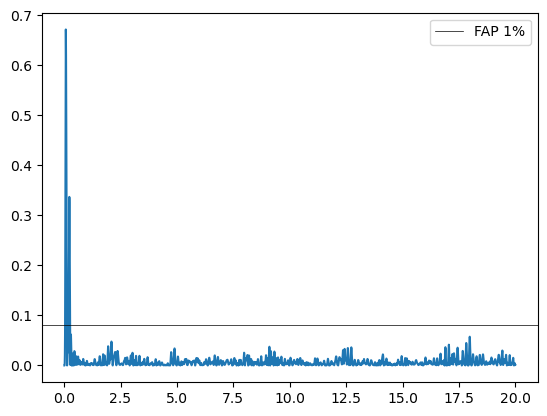

In [186]:
plt.plot(w,power)
plt.axhline(0.0809, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

#### Coordenada Y

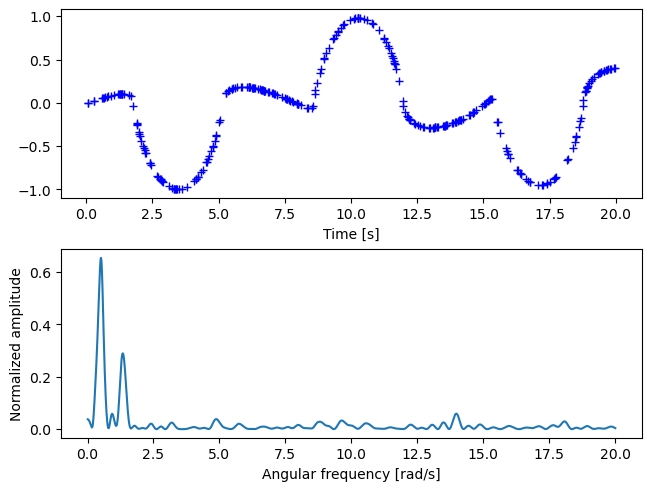

In [187]:
pgram = signal.lombscargle(t, y_4, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_4, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

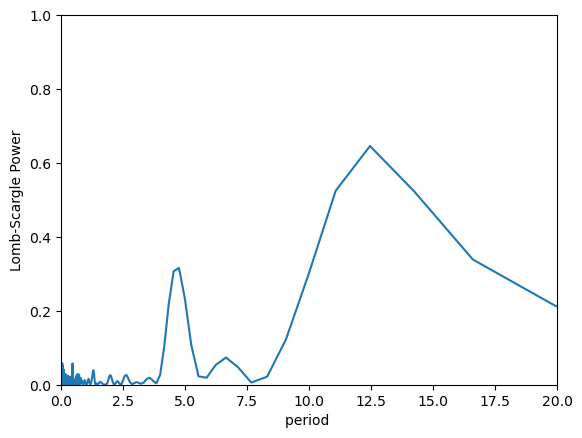

In [188]:
model = LombScargleFast().fit(t, y_4)
periods, power = model.periodogram_auto(nyquist_factor=20)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 20), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power');

In [189]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 4.5 #limite infererior del intervalo
f_end = 5.5 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_4)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.316
 - Using 10 steps per peak; omega_step = 0.0316
 - User-specified period range:  4.4 to 5.5
 - Computing periods at 10 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 1.3538293894344016


In [190]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 10 #limite infererior del intervalo
f_end = 15 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, y_4)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.316
 - Using 10 steps per peak; omega_step = 0.0316
 - User-specified period range:  9.8 to 15
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 0.5167057949046858


In [192]:
ls = LombScargle(t, y_4, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.6460833132515843
FAP = 1.3065214793946136e-63


In [193]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06557543, 0.07032889, 0.08094792])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0657; para el 5%, 0,0705, y para el 1%, 0,081.

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

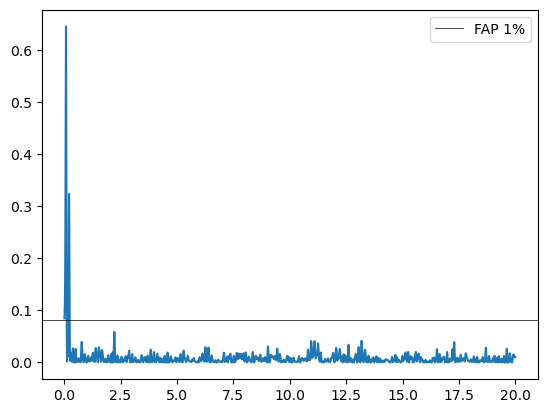

In [194]:
plt.plot(w,power)
plt.axhline(0.0809, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');